In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from pathlib import Path

# Add src to path
sys.path.append('../src')
from data_preprocessing import get_merged_data
from dual_change_point_model import DualChangePointModel # Importing the new class

# Visual Style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (16, 8)

print("Dual Change Point Environment Ready.")

/Users/admin/week11/brent-oil-bayesian-change-point-analysis/.venv/lib/python3.10/site-packages/arviz/__init__.py:50: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


Dual Change Point Environment Ready.


In [2]:
# 1. Load Data
prices, events = get_merged_data()

# 2. Initialize the Dual Model
model_dual = DualChangePointModel(prices)

print(f"Loaded {len(prices)} price records.")

Loading price data from: /Users/admin/week11/brent-oil-bayesian-change-point-analysis/Backend/data/raw/BrentOilPrices.csv
Successfully loaded 9010 price records.
Date Range: 1987-05-21 to 2022-11-14
Loading event data from: /Users/admin/week11/brent-oil-bayesian-change-point-analysis/Backend/data/processed/key_events.csv
Successfully loaded 22 events.
Loaded 9010 price records.


In [3]:
import arviz as az
import matplotlib.dates as mdates

def plot_full_diagnostics(trace, window_df, event_name, true_event_date):
    """
    Generates the 5-layer diagnostic report requested:
    1. Price Chart with Estimated Change Points
    2. Comparison: True vs Estimated
    3. Posterior Distributions of Regime Means (Sigmas)
    4. Posterior Distributions of Change Points (Taus)
    5. MCMC Trace plots
    """
    if trace is None: return

    # --- PRE-CALCULATIONS ---
    # 1. Get Median Dates for Change Points
    t1_idx = int(trace.posterior['tau_1'].median())
    t2_idx = int(trace.posterior['tau_2'].median())
    date_est_start = window_df.index[t1_idx]
    date_est_end = window_df.index[t2_idx]

    # 2. Get Mean Volatilities
    s1 = trace.posterior['sigma_1'].mean().item()
    s2 = trace.posterior['sigma_2'].mean().item()
    s3 = trace.posterior['sigma_3'].mean().item()

    print(f"--- DIAGNOSTIC REPORT: {event_name} ---")

    # =========================================================
    # PLOT 1 & 2: Price Chart + True vs Estimated Comparison
    # =========================================================
    fig, ax = plt.subplots(figsize=(18, 7))

    # A. The Data
    ax.plot(window_df.index, window_df['Log_Return'], color='black', alpha=0.4, lw=1, label='Log Returns')

    # B. The Estimates (Red & Blue Dashed)
    ax.axvline(date_est_start, color='red', linestyle='--', lw=2, label=f'Est. Start: {date_est_start.date()}')
    ax.axvline(date_est_end, color='blue', linestyle='--', lw=2, label=f'Est. End: {date_est_end.date()}')

    # C. The True Event (Green Solid)
    true_date = pd.to_datetime(true_event_date)
    if true_date >= window_df.index[0] and true_date <= window_df.index[-1]:
        ax.axvline(true_date, color='green', linestyle='-', lw=3, alpha=0.8, label=f'True Event: {true_date.date()}')

    # D. Regime Shading
    ax.axvspan(window_df.index[0], date_est_start, color='green', alpha=0.1)
    ax.axvspan(date_est_start, date_est_end, color='red', alpha=0.1)
    ax.axvspan(date_est_end, window_df.index[-1], color='blue', alpha=0.1)

    ax.set_title(f"1. & 2. Price Chart & Event Comparison: {event_name}", fontsize=16, fontweight='bold')
    ax.legend(loc='upper left', frameon=True, shadow=True)
    plt.show()

    # =========================================================
    # PLOT 3: Posterior Distributions of Regime Means (Sigmas)
    # =========================================================
    print("Generating Posterior Means (Volatility Levels)...")
    az.plot_posterior(
        trace,
        var_names=["sigma_1", "sigma_2", "sigma_3"],
        figsize=(18, 5),
        textsize=12,
        ref_val=None,
        color='purple'
    )
    plt.suptitle(f"3. Posterior Distributions of Regime Means (Volatility)", fontsize=16, y=1.05)
    plt.show()

    # =========================================================
    # PLOT 4: Posterior Distributions of Change Points (Taus)
    # =========================================================
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

    # Tau 1 Histogram (Start of Crisis)
    tau_1_samples = trace.posterior['tau_1'].values.flatten()
    ax1.hist(window_df.index[tau_1_samples], bins=30, density=True, color='red', alpha=0.6)
    ax1.set_title(f"4a. Posterior of Crisis START (Tau 1)\nMost Likely: {date_est_start.date()}")
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.tick_params(axis='x', rotation=45)

    # Tau 2 Histogram (End of Crisis)
    tau_2_samples = trace.posterior['tau_2'].values.flatten()
    ax2.hist(window_df.index[tau_2_samples], bins=30, density=True, color='blue', alpha=0.6)
    ax2.set_title(f"4b. Posterior of Crisis END (Tau 2)\nMost Likely: {date_est_end.date()}")
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # =========================================================
    # PLOT 5: MCMC Trace Plots (Convergence Check)
    # =========================================================
    print("Generating MCMC Trace Plots...")
    az.plot_trace(trace, var_names=["sigma_1", "sigma_2", "sigma_3", "tau_1", "tau_2"], compact=True)
    plt.suptitle(f"5. MCMC Trace Plots (Convergence Check)", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()


   ANALYZING: Global Financial Crisis
Running Dual-Point Analysis for 2008-09-15 (503 obs)...


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [tau_1]
>>Metropolis: [tau_2]
>NUTS: [sigma_1, sigma_2, sigma_3]


Output()

Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- DIAGNOSTIC REPORT: Global Financial Crisis ---


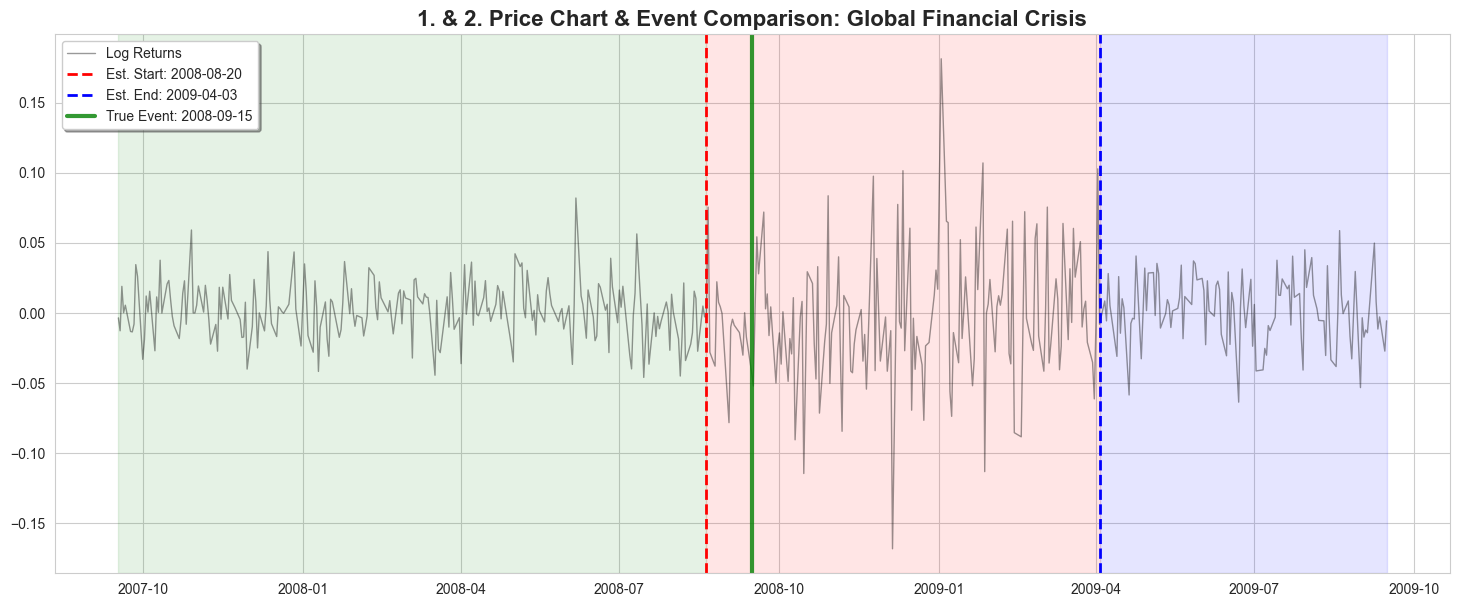

Generating Posterior Means (Volatility Levels)...


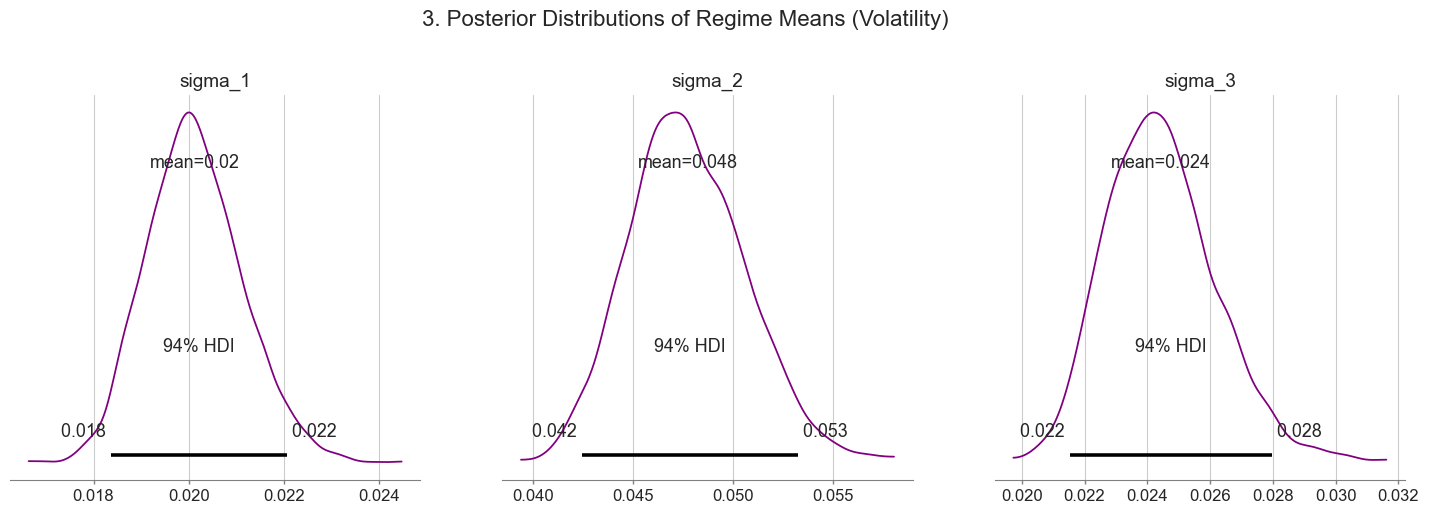

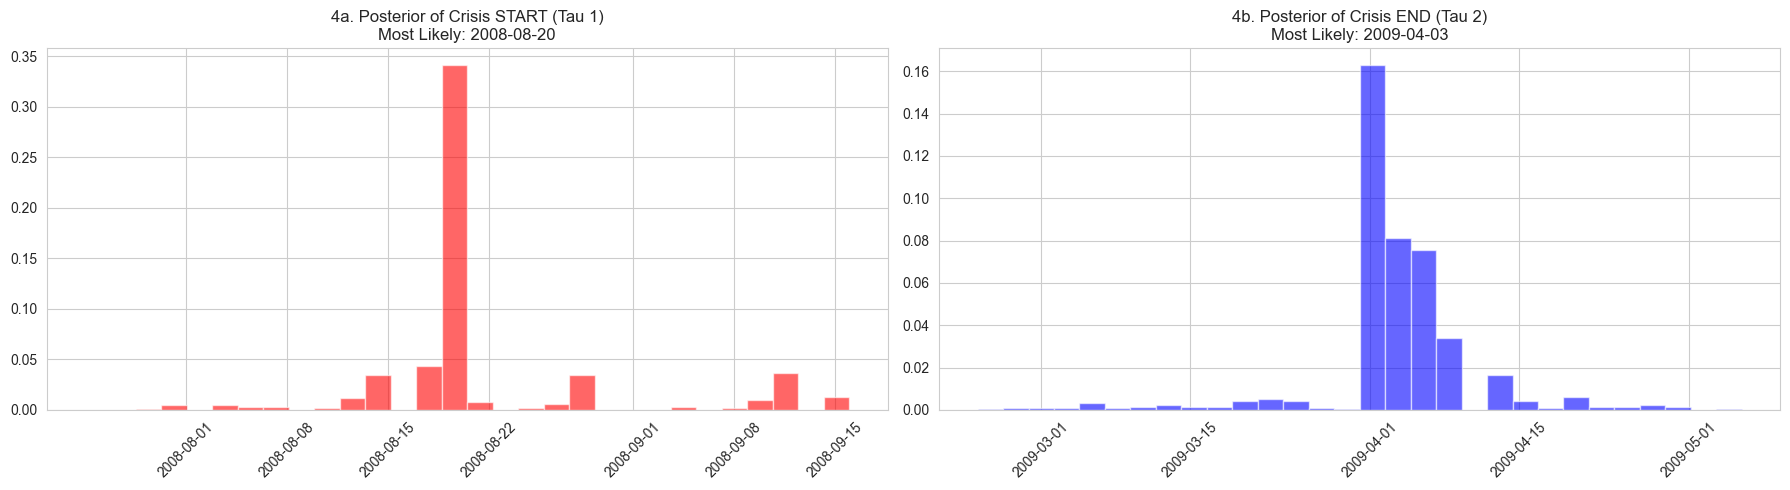

Generating MCMC Trace Plots...


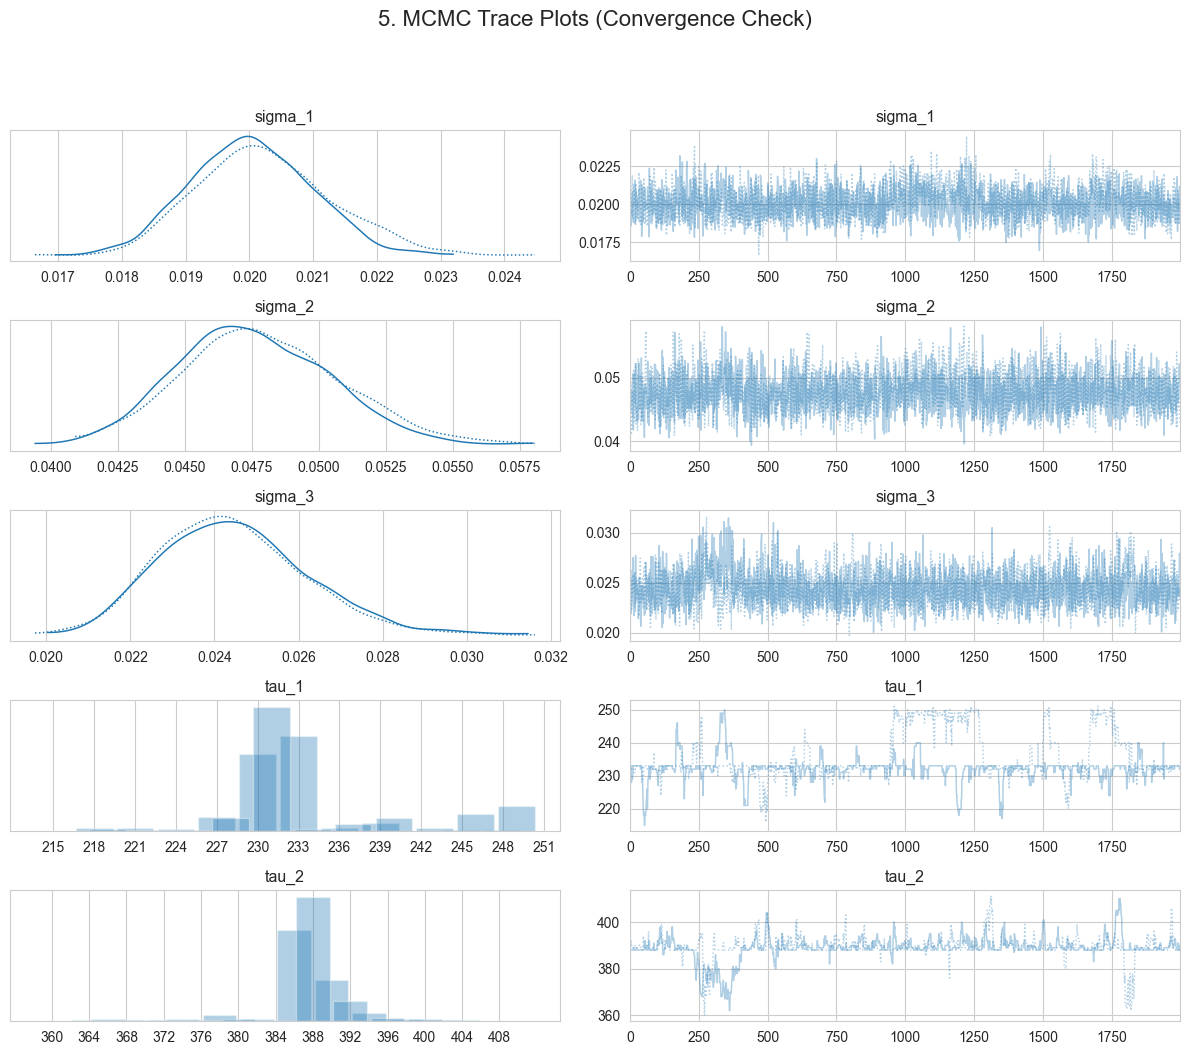


   ANALYZING: COVID-19 Global Lockdowns
Running Dual-Point Analysis for 2020-03-11 (280 obs)...


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [tau_1]
>>Metropolis: [tau_2]
>NUTS: [sigma_1, sigma_2, sigma_3]


Output()

Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- DIAGNOSTIC REPORT: COVID-19 Global Lockdowns ---


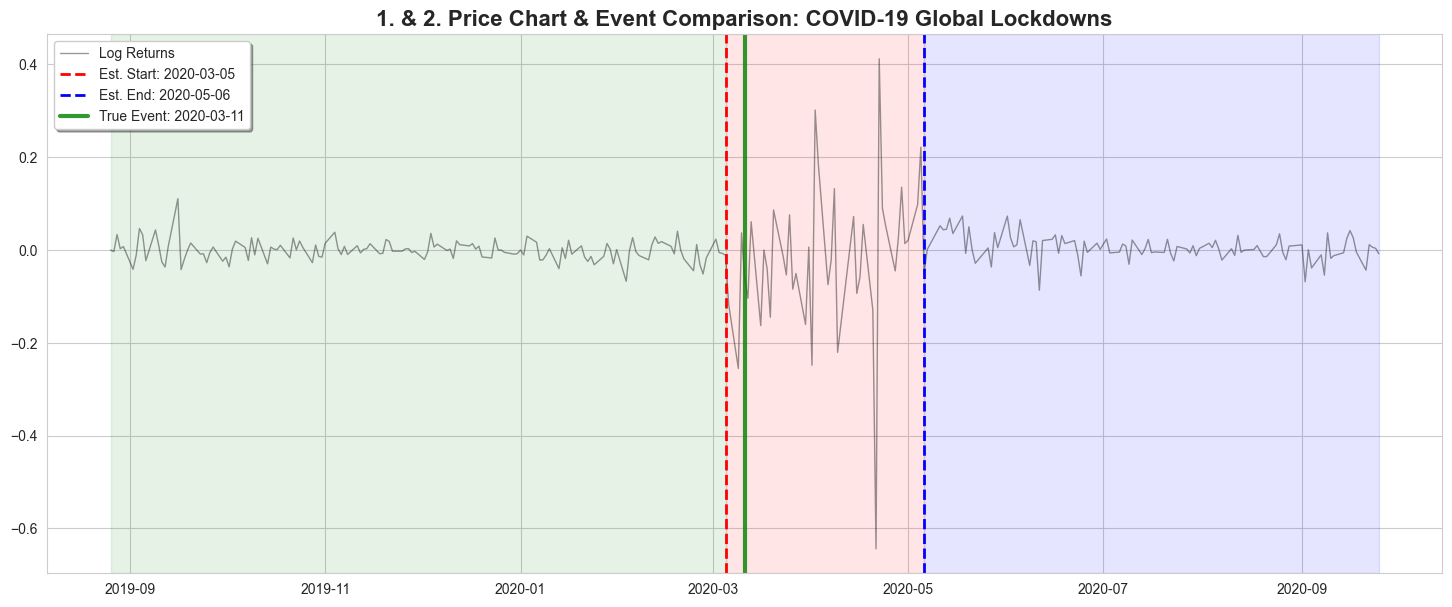

Generating Posterior Means (Volatility Levels)...


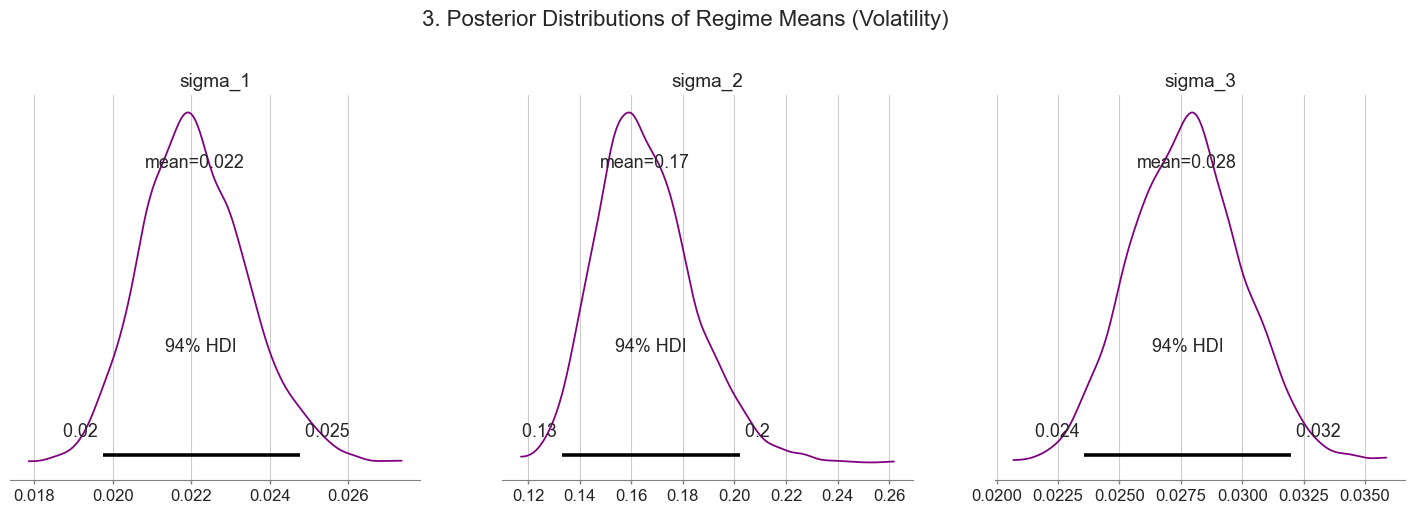

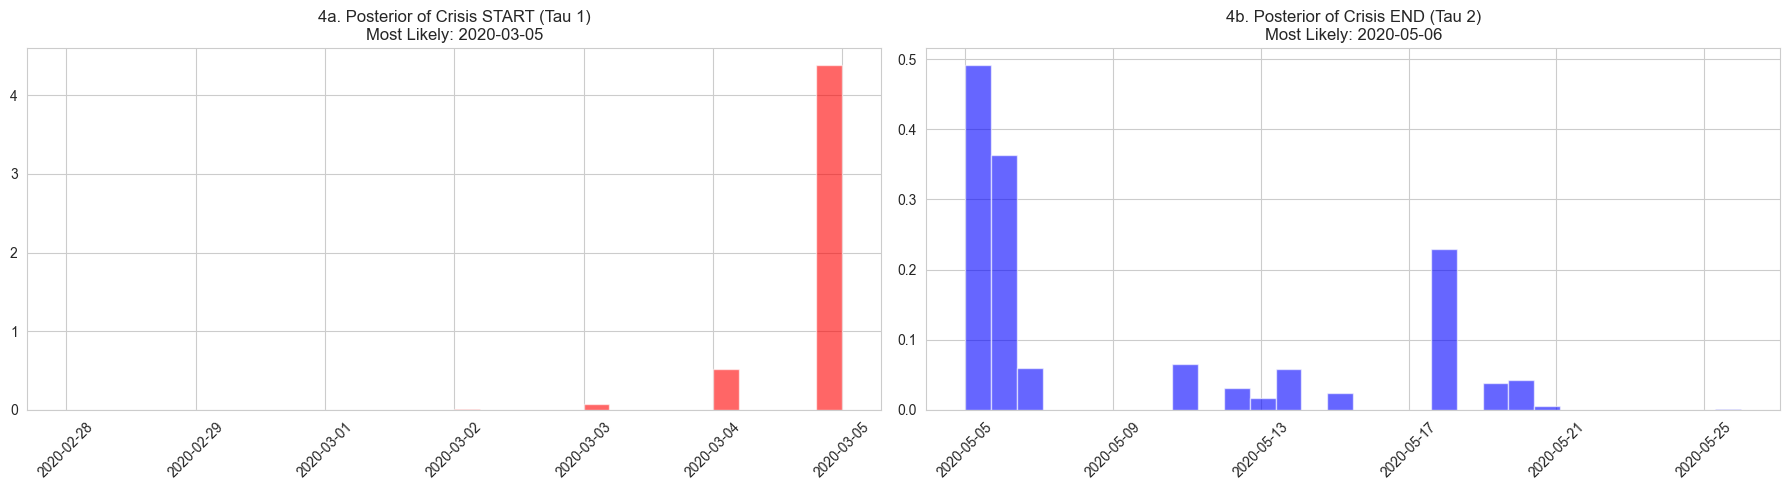

Generating MCMC Trace Plots...


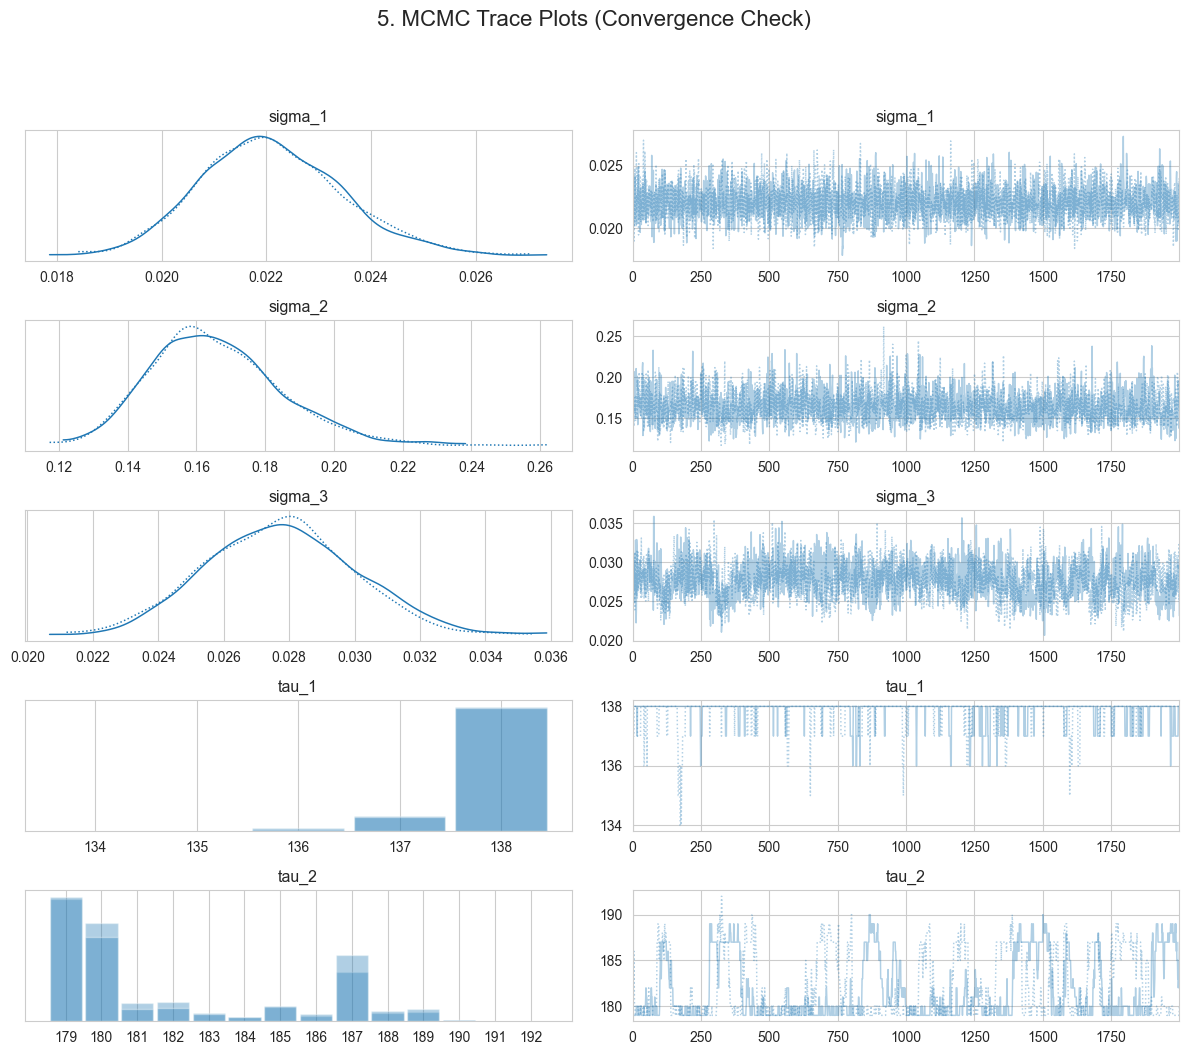


   ANALYZING: First Gulf War
Running Dual-Point Analysis for 1990-08-02 (281 obs)...


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [tau_1]
>>Metropolis: [tau_2]
>NUTS: [sigma_1, sigma_2, sigma_3]


Output()

Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- DIAGNOSTIC REPORT: First Gulf War ---


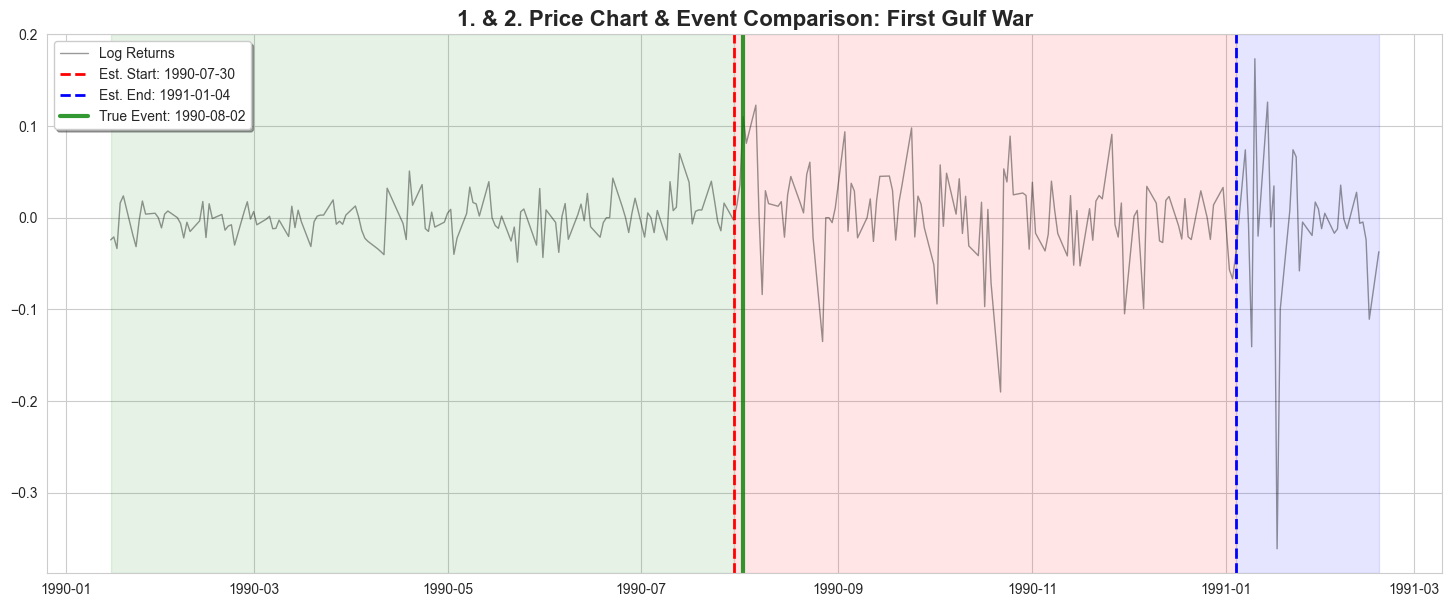

Generating Posterior Means (Volatility Levels)...


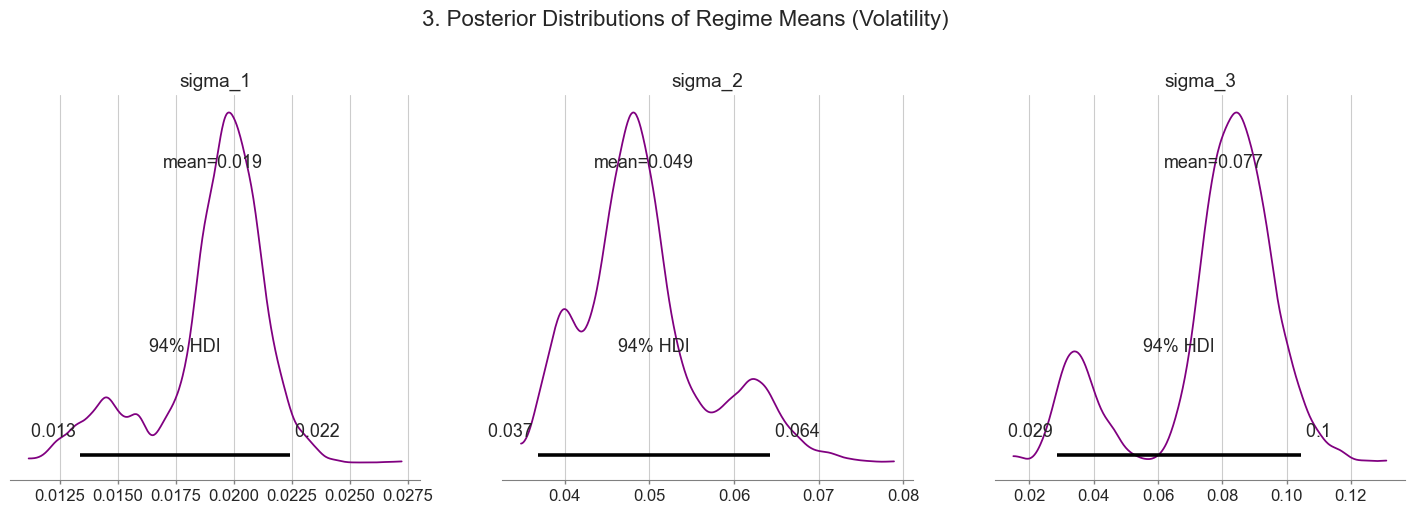

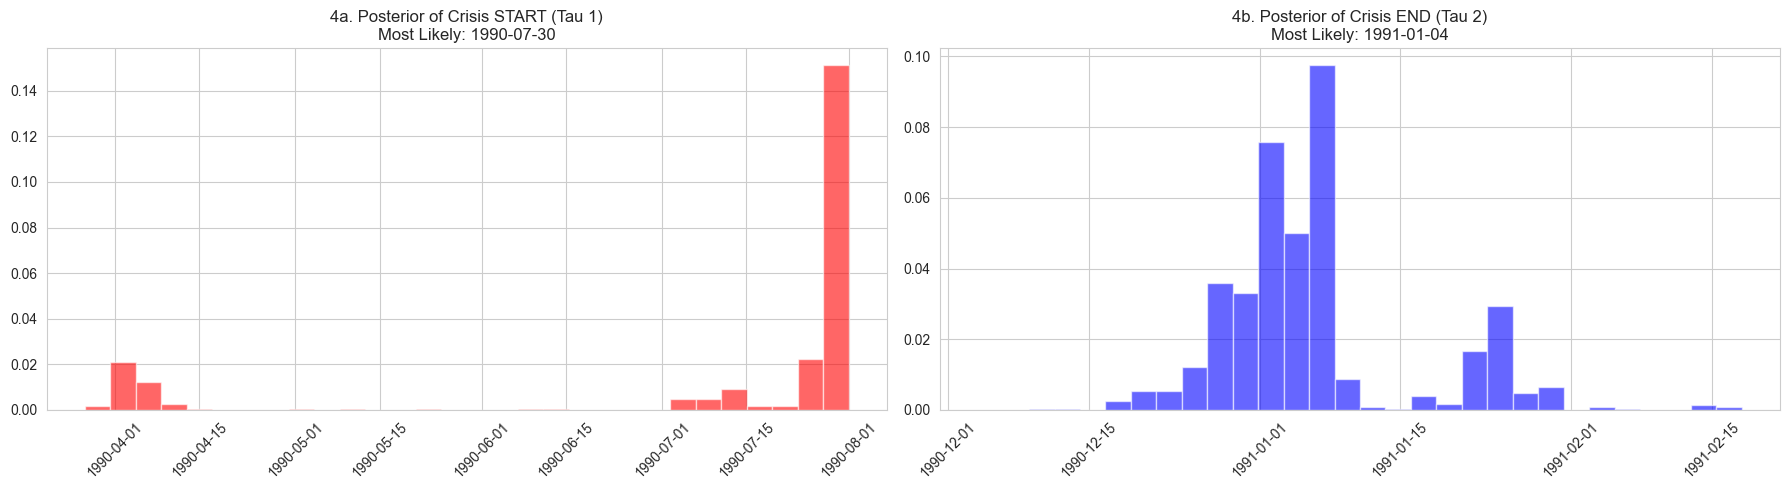

Generating MCMC Trace Plots...


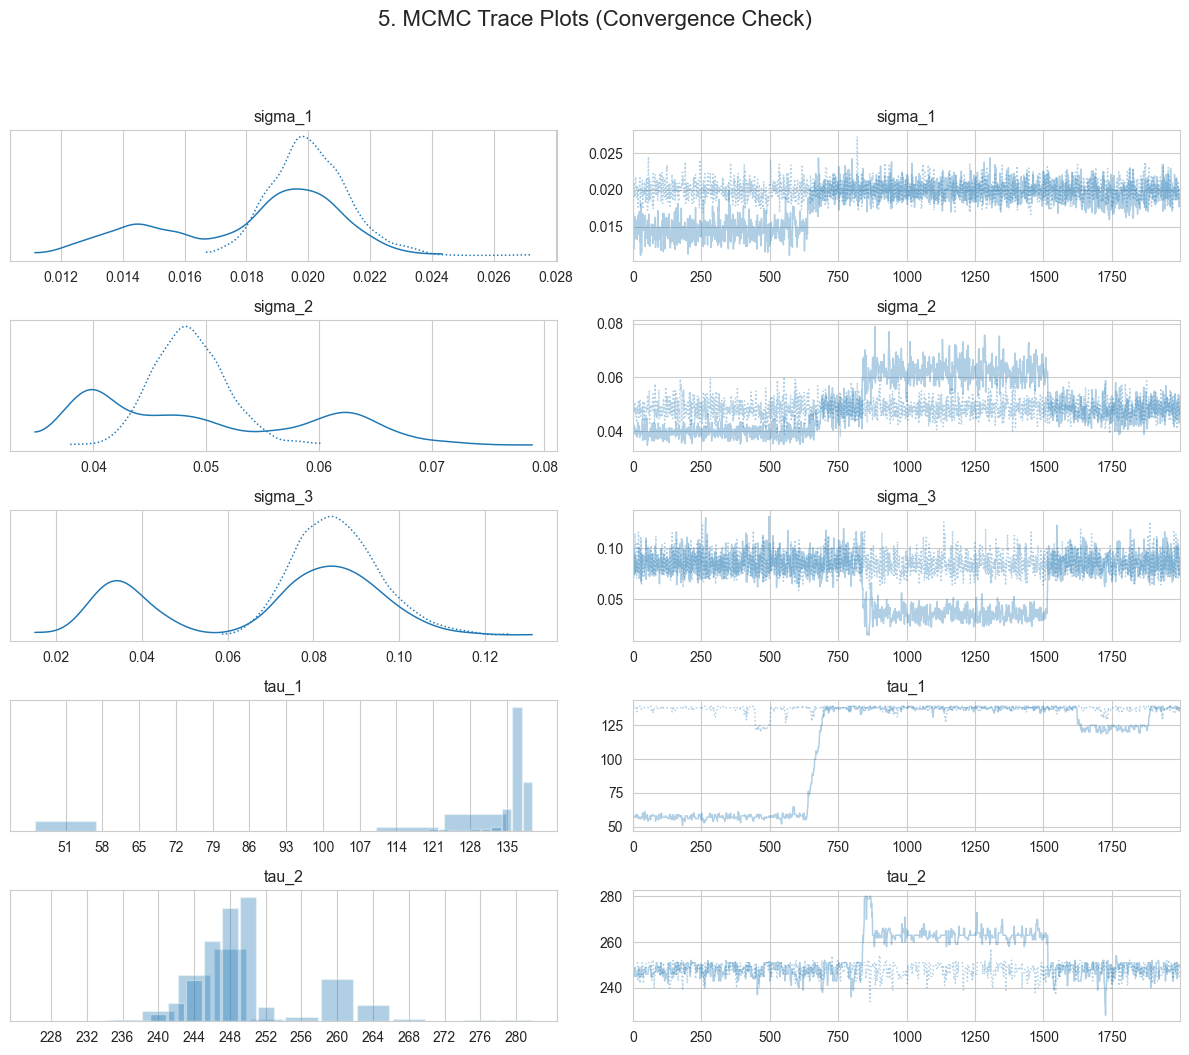

In [4]:
# Select the events that have a clear "Start" and "End"
deep_dive_targets = [
    {'Name': 'Global Financial Crisis', 'Date': '2008-09-15', 'Window': 365},
    {'Name': 'COVID-19 Global Lockdowns', 'Date': '2020-03-11', 'Window': 200},
    {'Name': 'First Gulf War', 'Date': '1990-08-02', 'Window': 200}
]

for event in deep_dive_targets:
    print(f"\n========================================================")
    print(f"   ANALYZING: {event['Name']}")
    print(f"========================================================")

    # Run the Dual Model
    trace, window_df = model_dual.analyze_event(event['Date'], window_days=event['Window'])

    # Generate the 5-Layer Report
    if trace:
        plot_full_diagnostics(trace, window_df, event['Name'], event['Date'])

Generating Universal Plot for 2008 Crisis (Using DUAL Model)...
Loading price data from: /Users/admin/week11/brent-oil-bayesian-change-point-analysis/Backend/data/raw/BrentOilPrices.csv
Successfully loaded 9010 price records.
Date Range: 1987-05-21 to 2022-11-14
Loading event data from: /Users/admin/week11/brent-oil-bayesian-change-point-analysis/Backend/data/processed/key_events.csv
Successfully loaded 22 events.
Running Dual-Point Analysis for 2008-09-15 (503 obs)...


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [tau_1]
>>Metropolis: [tau_2]
>NUTS: [sigma_1, sigma_2, sigma_3]


Output()

Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Detected DUAL Change Point Model for Global Financial Crisis


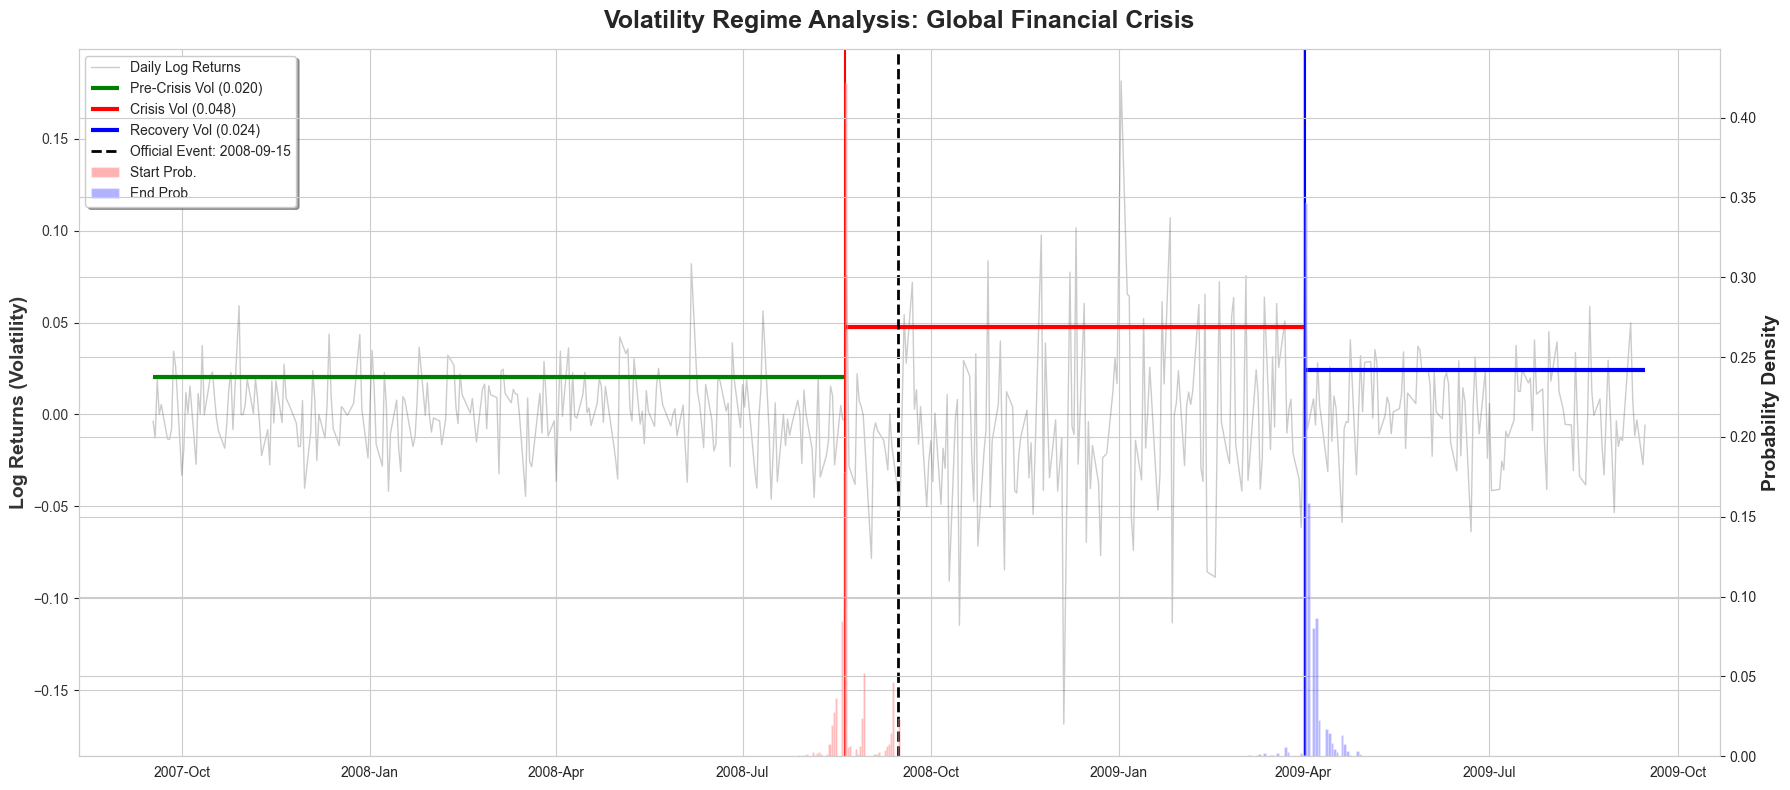

In [11]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np

def plot_volatility_regime_shift(trace, window_df, event_name, true_event_date):
    """
    Universal Volatility Plotter.
    Automatically detects if the model is SINGLE (1 break) or DUAL (2 breaks)
    and adapts the visualization.
    """
    if trace is None: return

    # --- 1. DETECT MODEL TYPE ---
    is_dual = 'tau_1' in trace.posterior.data_vars

    # --- 2. PLOT SETUP ---
    fig, ax1 = plt.subplots(figsize=(18, 8))
    ax2 = ax1.twinx() # Secondary axis for probability

    # Common: Plot Log Returns (The "Noise")
    color_vol = '#333333'
    ax1.plot(window_df.index, window_df['Log_Return'], color=color_vol, alpha=0.25, lw=1, label='Daily Log Returns')
    ax1.set_ylabel('Log Returns (Volatility)', color=color_vol, fontsize=14, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor=color_vol)

    # --- 3. HANDLE DUAL MODEL (Crisis Start & End) ---
    if is_dual:
        print(f"Detected DUAL Change Point Model for {event_name}")

        # A. Extract Data
        t1_samples = trace.posterior['tau_1'].values.flatten()
        t2_samples = trace.posterior['tau_2'].values.flatten()

        # Get Dates
        date_t1 = window_df.index[int(pd.Series(t1_samples).mode()[0])]
        date_t2 = window_df.index[int(pd.Series(t2_samples).mode()[0])]

        # Get Volatilities
        s1 = trace.posterior['sigma_1'].mean().item() # Pre
        s2 = trace.posterior['sigma_2'].mean().item() # Crisis
        s3 = trace.posterior['sigma_3'].mean().item() # Post

        # B. Plot Volatility Levels (3 Lines)
        ax1.hlines(y=s1, xmin=window_df.index[0], xmax=date_t1, color='green', lw=3, label=f'Pre-Crisis Vol ({s1:.3f})')
        ax1.hlines(y=s2, xmin=date_t1, xmax=date_t2, color='red', lw=3, label=f'Crisis Vol ({s2:.3f})')
        ax1.hlines(y=s3, xmin=date_t2, xmax=window_df.index[-1], color='blue', lw=3, label=f'Recovery Vol ({s3:.3f})')

        # C. Plot Probability Curves (2 Hills)
        # Tau 1 (Start) -> Red Hill
        ax2.hist(window_df.index[t1_samples], bins=50, density=True, color='red', alpha=0.3, label='Start Prob.')
        # Tau 2 (End) -> Blue Hill
        ax2.hist(window_df.index[t2_samples], bins=50, density=True, color='blue', alpha=0.3, label='End Prob.')

        ax1.axvline(date_t1, color='red', linestyle='-', lw=1.5)
        ax1.axvline(date_t2, color='blue', linestyle='-', lw=1.5)

    # --- 4. HANDLE SINGLE MODEL (Before vs After) ---
    else:
        print(f"Detected SINGLE Change Point Model for {event_name}")

        # A. Extract Data
        tau_samples = trace.posterior['tau'].values.flatten()
        date_tau = window_df.index[int(pd.Series(tau_samples).mode()[0])]

        s1 = trace.posterior['sigma_1'].mean().item()
        s2 = trace.posterior['sigma_2'].mean().item()

        # B. Plot Levels
        ax1.hlines(y=s1, xmin=window_df.index[0], xmax=date_tau, color='green', lw=3, label=f'Pre-Event Vol ({s1:.3f})')
        ax1.hlines(y=s2, xmin=date_tau, xmax=window_df.index[-1], color='red', lw=3, label=f'Post-Event Vol ({s2:.3f})')

        # C. Plot Probability (1 Hill)
        color_prob = '#1f77b4'
        ax2.hist(window_df.index[tau_samples], bins=50, density=True, color=color_prob, alpha=0.3, label='Change Prob.')
        ax1.axvline(date_tau, color=color_prob, linestyle='-', lw=2)

    # --- 5. FINAL TOUCHES ---
    # True Event Date
    true_date = pd.to_datetime(true_event_date)
    if true_date >= window_df.index[0] and true_date <= window_df.index[-1]:
        ax1.axvline(true_date, color='black', linestyle='--', lw=2, label=f'Official Event: {true_date.date()}')

    ax2.set_ylabel('Probability Density', fontsize=14, fontweight='bold')
    plt.title(f"Volatility Regime Analysis: {event_name}", fontsize=18, fontweight='bold', pad=15)

    # Combined Legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True, shadow=True)

    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    plt.tight_layout()
    plt.show()

# --- TEST IT WITH THE DUAL MODEL ---
print("Generating Universal Plot for 2008 Crisis (Using DUAL Model)...")

# 1. Import DUAL Model
from dual_change_point_model import DualChangePointModel
from data_preprocessing import get_merged_data

# 2. Setup
prices_test, _ = get_merged_data()
model_dual_test = DualChangePointModel(prices_test)

# 3. Run (Dual)
trace_dual, window_df_dual = model_dual_test.analyze_event('2008-09-15', window_days=365)

# 4. Plot (The Function will auto-detect Dual mode!)
plot_volatility_regime_shift(trace_dual, window_df_dual, 'Global Financial Crisis', '2008-09-15')